# Numerical results for the XXZ model Gibbs state

This notebook reproduces the numerical results of the paper ["On the Sample Complexity of Quantum Boltzmann Machine Learning"](http://arxiv.org/abs/2306.14969). 

The XXZ model Hamiltonian in 1D is

$$
\mathcal{H}_{\mathrm{XXZ}}=\sum_{i=1}^{n-1} J\left(\sigma_i^x \sigma_{i+1}^x+\sigma_i^y \sigma_{i+1}^y\right)+\Delta \sigma_i^z \sigma_{i+1}^z+\sum_{i=1}^n h_z \sigma_i^z
$$

and the target state is

$$
\eta=\frac{e^{\mathcal{H}_{\mathrm{XXZ}}}}{Z}
$$

We choose the parameters

* $J=-0.5$
* $\Delta=-0.7$
* $h_z=-0.8$

In [1]:
J = -0.5
Delta = -0.7
hz = -0.8

## Define the parameters of the model: QBM

Here we select the number of qubits of the Gibbs state, the model Hamiltonian to use in the definition of the QBM, and the training hyperparameters. We do not add noise to the training.

In [2]:
import numpy as np

##########
# CONFIG #
##########

rng = np.random.default_rng(seed=1)

n_qubits = 4
model_label = 6 # 6: Geometrically local 1D chain
depolarizing_noise = 0.0 # if noisy expectation values
learning_rate = 0.02
epochs = 1000
eps = 0.01  # stop if the gradients are smaller than this
compute_qre = True



The model Hamiltonian is defined as a list of operators $H = \sum_{i=0}^m \theta_i H_i $

In [3]:
from qbm_quimb import hamiltonians
# A list of operators in the model Hamiltonian
model_ham_ops, model_ham_names = hamiltonians.hamiltonian_operators(n_qubits, model_label, return_names=True)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
# this is the list of operator names
model_ham_names

['X_0_1',
 'X_1_2',
 'X_2_3',
 'X_0',
 'X_1',
 'X_2',
 'X_3',
 'Y_0_1',
 'Y_1_2',
 'Y_2_3',
 'Y_0',
 'Y_1',
 'Y_2',
 'Y_3',
 'Z_0_1',
 'Z_1_2',
 'Z_2_3',
 'Z_0',
 'Z_1',
 'Z_2',
 'Z_3']

In [5]:
m = len(model_ham_names)
print(f"The Hamiltonian has {m} different operators.")

The Hamiltonian has 21 different operators.


Each operator is of shape $2^n \times 2^n$

In [6]:
print(model_ham_ops[0].shape)

(16, 16)


## Define the data

Here we work with _quantum_ data in the form of the Gibbs state of a target Hamiltonian at a fixed inverse temperature $\beta$.
The target Hamiltonian is a subset of the model Hamiltonian.


In [7]:
from qbm_quimb import data

########
# DATA #
########

# We use the label 6 to generate the terms in the target hamiltonian
# but we fix them using J, Delta, and hz
target_label = 6
# we have N-qubits-1 links
n_links = n_qubits -1 
target_params = np.array(n_links * [J] + n_qubits * [0] + n_links * [J] + n_qubits * [0] + n_links * [Delta] + n_qubits * [hz])
target_beta = -1.0  # use -1 to match with the definition of the thermal state

In [8]:
assert target_params.shape[0] == m

In [9]:
# generate expectation values: quantum data
target_expects, target_state = data.generate_data(
    n_qubits,
    target_label,
    target_params,
    target_beta,
    model_ham_ops,
    depolarizing_noise,
)

The expectation values of the model Hamiltonian operators are computed with respect to the target Gibbs state.

In [10]:
target_expects  # expectation values w.r.t. target density matrix

[-0.4656640001798008,
 -0.4473469096987973,
 -0.46566400017980125,
 4.3845086613330065e-17,
 6.914681537656912e-17,
 -7.962046540739132e-17,
 5.21593229966328e-18,
 -0.4656640001798008,
 -0.4473469096987973,
 -0.46566400017980125,
 2.7733391199176196e-32j,
 3.4666738998970245e-33j,
 -3.851859888774472e-33j,
 4.7955655615242173e-32j,
 -0.4086864138659327,
 -0.4919460461791575,
 -0.40868641386593313,
 -0.37920165144017504,
 -0.11550306008696522,
 -0.11550306008696494,
 -0.37920165144017476]

Text(0, 0.5, 'Expectation values')

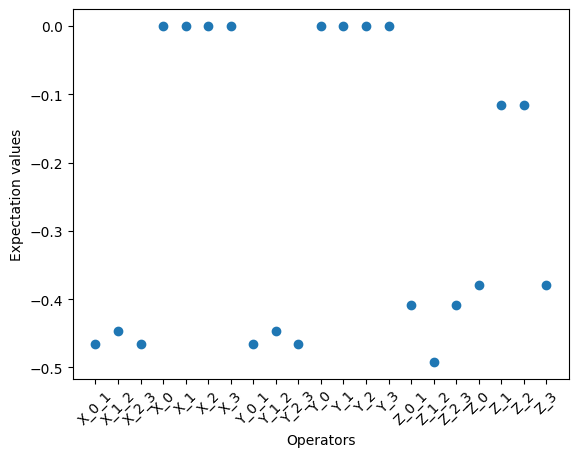

In [11]:
import matplotlib.pyplot as plt

plt.plot(np.asarray(target_expects).real,"o")
plt.xticks(np.arange(len(model_ham_names)), model_ham_names, rotation=45)
plt.xlabel("Operators")
plt.ylabel("Expectation values")

## Start the training by minimizing the relative entropy

We initialize the parameters of the model QBM and then train with stochastic gradient descent (SGD)

In [12]:
from qbm_quimb.training import QBM, train_qbm


#############
# QBM Model #
#############

initial_params = rng.normal(size=len(model_ham_ops))
qbm_state = QBM(model_ham_ops, initial_params)
print(f"Initial parameters: {qbm_state.get_coeffs()}")
print(f"Target parameters: {target_params}")
print(f"Target beta: {target_beta}")




Initial parameters: [ 0.34558419  0.82161814  0.33043708 -1.30315723  0.90535587  0.44637457
 -0.53695324  0.5811181   0.3645724   0.2941325   0.02842224  0.54671299
 -0.73645409 -0.16290995 -0.48211931  0.59884621  0.03972211 -0.29245675
 -0.78190846 -0.25719224  0.00814218]
Target parameters: [-0.5 -0.5 -0.5  0.   0.   0.   0.  -0.5 -0.5 -0.5  0.   0.   0.   0.
 -0.7 -0.7 -0.7 -0.8 -0.8 -0.8 -0.8]
Target beta: -1.0


In [13]:
import quimb as qu
################
# QBM Taininig #
################

target_eta = target_state
target_evals = qu.eigvalsh(target_eta).clip(1e-300)  # clip near zero for numerical reasons

qbm_state, max_grads_hist, qre_hist = train_qbm(
    qbm=qbm_state,
    target_expects=target_expects,
    learning_rate=learning_rate,
    epochs=epochs,
    eps=eps,
    compute_qre=compute_qre,
    target_eta=target_eta,
    target_eta_ev=target_evals,
)

print(f"Trained parameters: {qbm_state.get_coeffs()}")
print(f"Max. gradients: {max_grads_hist[-1]}")

print(f"Initial relative entropy: {qre_hist[0]}")
print(f"Trained relative entropy: {qre_hist[-1]}")

Trained parameters: [-4.96651604e-01 -4.88609361e-01 -5.00871811e-01  9.77051475e-05
  2.54160488e-04  3.03128290e-04  1.55296200e-04 -4.98684897e-01
 -4.86156167e-01 -5.01993014e-01  1.84788320e-05 -7.80062820e-05
 -2.34414200e-04 -1.62674817e-04 -6.53851893e-01 -6.80202015e-01
 -6.13960230e-01 -7.58353702e-01 -7.29910181e-01 -6.93963643e-01
 -7.24877618e-01]
Max. gradients: 0.009991096797078186
Initial relative entropy: 4.566710135251047
Trained relative entropy: 0.0014259153401408042


The relative entropy after training is close to zero, and this is reproducing the left side of panel (a) in Figure 2 of the paper. In the paper they also stopped the training when the gradients were smaller than `eps=0.01`

## Plot training history

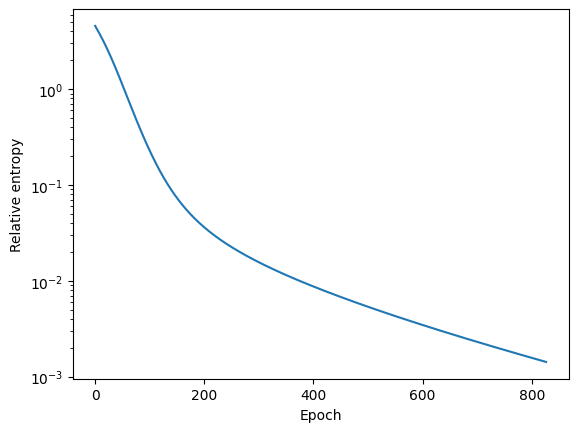

In [14]:
plt.plot(qre_hist[1:], "-")
plt.xlabel("Epoch")
plt.ylabel("Relative entropy")
plt.yscale('log')
plt.show()


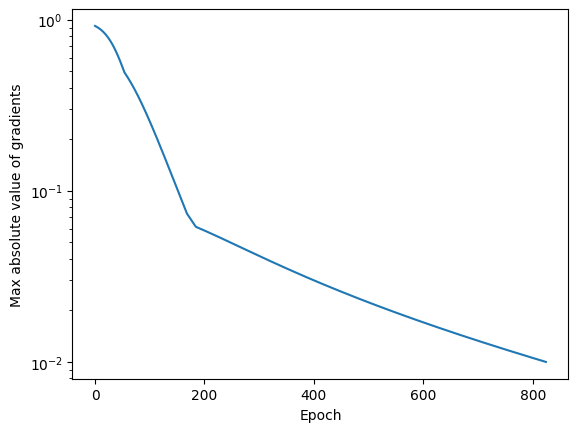

In [15]:
plt.plot(max_grads_hist[1:], "-")
plt.xlabel("Epoch")
plt.ylabel("Max absolute value of gradients")
plt.yscale('log')
plt.show()

## Compare the parameters

In [16]:
# target parameters
print(target_params)

[-0.5 -0.5 -0.5  0.   0.   0.   0.  -0.5 -0.5 -0.5  0.   0.   0.   0.
 -0.7 -0.7 -0.7 -0.8 -0.8 -0.8 -0.8]


In [17]:
# model parameters
print(qbm_state.get_coeffs())

[-4.96651604e-01 -4.88609361e-01 -5.00871811e-01  9.77051475e-05
  2.54160488e-04  3.03128290e-04  1.55296200e-04 -4.98684897e-01
 -4.86156167e-01 -5.01993014e-01  1.84788320e-05 -7.80062820e-05
 -2.34414200e-04 -1.62674817e-04 -6.53851893e-01 -6.80202015e-01
 -6.13960230e-01 -7.58353702e-01 -7.29910181e-01 -6.93963643e-01
 -7.24877618e-01]


Text(0, 0.5, 'Paramters -> |target - model|')

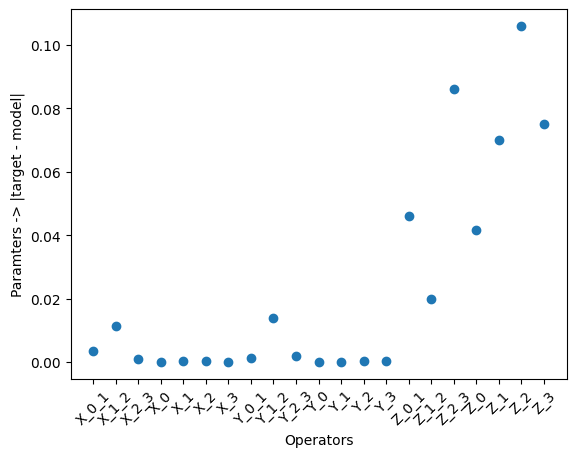

In [18]:
param_diff = np.fabs(target_params.real - qbm_state.get_coeffs().real)
plt.plot(param_diff, "o")
plt.xticks(np.arange(len(model_ham_names)), model_ham_names, rotation=45)
plt.xlabel("Operators")
plt.ylabel("Paramters -> |target - model|")

If we train for longer, to reach smaller gradients, this different will go down because we have no model mismatch.

## Check fidelity with the Gibbs state

In [19]:
from quimb import fidelity

fidelity(target_eta, qbm_state.get_density_matrix())

0.9996766825532727

Since the QBM model contains the operators of the Hamiltonian used to create the target quantum Gibbs state as a subset, the training is able to find the parameters correctly. Therefore the fidelity between the target state and the QBM state after training is very close to 1.

## Pretraining

In Fig. 2 of the paper, the authors compare different pre-training strategies. Pretraining can be implemented simply as 2 consecutive rounds of training, where the first one only affects a subset of the parameters.

To follow the paper we select different learning rates for the pretraining and the full training phases.

### Select the full QBM model

We will use a fully connected QBM model defined in equation (16) of the paper as:

$$
\mathcal{H}_\theta=\sum_{k=x, y, z} \sum_{i, j>i} \lambda_{i j}^k \sigma_i^k \sigma_j^k+\sum_i^n \gamma_i^k \sigma_i^k
$$


In [20]:
model_label = 8  # 8: Fully connected
model_ham_ops, model_ham_names = hamiltonians.hamiltonian_operators(
    n_qubits, model_label, return_names=True
)

In [21]:
m = len(model_ham_names)
print(f"We have {m} terms in the Hamiltonian")

We have 30 terms in the Hamiltonian


In [22]:
full_lr = 1/(2*m)
print(f"Learning rate for full training: {full_lr:.4f}")

Learning rate for full training: 0.0167


### Select pretraining strategy

We will pretrain by using a geometrically local Hamiltonian, whose operators are a subset of the full model

$$
\mathcal{H}_\theta^{\mathrm{GL}}=\sum_{k=x, y, z} \sum_{\langle i, j\rangle} \lambda_{i j}^k \sigma_i^k \sigma_j^k+\sum_i^n \gamma_i^k \sigma_i^k
$$

In [23]:
pre_model_label = 7  # 7: Geometrically local (2D lattice)
pre_model_ham_ops, pre_model_ham_names = hamiltonians.hamiltonian_operators(
    n_qubits, pre_model_label, return_names=True
)

In [24]:
pre_m = len(pre_model_ham_names)
print(f"We have {pre_m} terms in the pretraining Hamiltonian")

We have 24 terms in the pretraining Hamiltonian


In [25]:
pre_lr = 1 / pre_m
print(f"Learning rate for pretraining: {pre_lr:.4f}")

Learning rate for pretraining: 0.0417


### Generate data for pretraining and do pretraining

In [79]:
# generate expectation values: quantum data
target_expects, target_state = data.generate_data(
    n_qubits,
    target_label,
    target_params,
    target_beta,
    pre_model_ham_ops,
    depolarizing_noise,
)

The pretraining QBM state we use needs to start from parameters that are zero, that is the initial QBM is a maximally mixed state:

In [80]:
initial_params = np.zeros(shape=(len(pre_model_ham_ops)))
pre_qbm_state = QBM(pre_model_ham_ops, initial_params)
print(f"Initial parameters: {pre_qbm_state.get_coeffs()}")
print(f"Target parameters: {target_params}")
print(f"Target beta: {target_beta}")

Initial parameters: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Target parameters: [-0.5 -0.5 -0.5  0.   0.   0.   0.  -0.5 -0.5 -0.5  0.   0.   0.   0.
 -0.7 -0.7 -0.7 -0.8 -0.8 -0.8 -0.8]
Target beta: -1.0


In [72]:
# we train for 300 epoch in the pretraining phase
pre_epochs = 300

In [81]:
pre_qbm_state, max_grads_hist, qre_hist = train_qbm(
    qbm=pre_qbm_state,
    target_expects=target_expects,
    learning_rate=pre_lr,
    epochs=pre_epochs,
    compute_qre=compute_qre,
    target_eta=target_eta,
    target_eta_ev=target_evals,
)

print(f"Trained parameters: {pre_qbm_state.get_coeffs()}")
print(f"Max. gradients: {max_grads_hist[-1]}")

print(f"Initial relative entropy: {qre_hist[0]}")
print(f"Trained relative entropy: {qre_hist[-1]}")

Trained parameters: [-4.24058498e-01  2.34745392e-01  2.34745392e-01 -4.24058498e-01
  1.60938668e-16  1.39476361e-16 -7.48468994e-17 -1.26739128e-17
 -4.24058498e-01  2.34745392e-01  2.34745392e-01 -4.24058498e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -5.32450176e-01  2.67920714e-01  2.67920714e-01 -5.32450176e-01
 -6.88191343e-01 -3.58101122e-01 -3.58101122e-01 -6.88191343e-01]
Max. gradients: 0.008233466965404779
Initial relative entropy: 1.166089743617617
Trained relative entropy: 0.2851116361466155


In [82]:
pretraining_qre = qre_hist
assert len(pretraining_qre) == pre_epochs+1

### Generate data for full training and do full training

In [83]:
# generate expectation values: quantum data
target_expects, target_state = data.generate_data(
    n_qubits,
    target_label,
    target_params,
    target_beta,
    model_ham_ops,
    depolarizing_noise,
)

We need to initialize the parameters based on our pretraining strategy

In [84]:
pre_op_map = {k: v for k, v in zip(pre_model_ham_names, pre_qbm_state.get_coeffs(),)}

In [85]:
# initialize parameters from pre-training
initial_params = []
for op in model_ham_names:
    try:
        if op in pre_model_ham_names:
            initial_params.append(pre_op_map[op])
        else:
            initial_params.append(0.0)
    except KeyError:
        initial_params.append(0)

In [86]:
qbm_state = QBM(model_ham_ops, initial_params)
print(f"Initial parameters: {qbm_state.get_coeffs()}")
print(f"Target parameters: {target_params}")
print(f"Target beta: {target_beta}")

Initial parameters: [-0.4240584975761422, 0.2347453920848833, 0.0, 0.0, 0.23474539208488387, -0.42405849757614267, 1.6093866750308e-16, 1.3947636110535021e-16, -7.484689938140629e-17, -1.2673912801751397e-17, -0.4240584975761422, 0.2347453920848833, 0.0, 0.0, 0.23474539208488387, -0.42405849757614267, 0.0, 0.0, 0.0, 0.0, -0.5324501764688147, 0.2679207137564897, 0.0, 0.0, 0.2679207137564902, -0.5324501764688148, -0.688191343443312, -0.3581011222363647, -0.3581011222363642, -0.6881913434433112]
Target parameters: [-0.5 -0.5 -0.5  0.   0.   0.   0.  -0.5 -0.5 -0.5  0.   0.   0.   0.
 -0.7 -0.7 -0.7 -0.8 -0.8 -0.8 -0.8]
Target beta: -1.0


In [87]:
# we do full training for 1000 epochs
full_epochs = 1000

In [88]:
qbm_state, max_grads_hist, qre_hist = train_qbm(
    qbm=qbm_state,
    target_expects=target_expects,
    learning_rate=full_lr,
    epochs=full_epochs,
    compute_qre=compute_qre,
    target_eta=target_eta,
    target_eta_ev=target_evals,
)

print(f"Trained parameters: {pre_qbm_state.get_coeffs()}")
print(f"Max. gradients: {max_grads_hist[-1]}")

print(f"Initial relative entropy: {qre_hist[0]}")
print(f"Trained relative entropy: {qre_hist[-1]}")

Trained parameters: [-4.24058498e-01  2.34745392e-01  2.34745392e-01 -4.24058498e-01
  1.60938668e-16  1.39476361e-16 -7.48468994e-17 -1.26739128e-17
 -4.24058498e-01  2.34745392e-01  2.34745392e-01 -4.24058498e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -5.32450176e-01  2.67920714e-01  2.67920714e-01 -5.32450176e-01
 -6.88191343e-01 -3.58101122e-01 -3.58101122e-01 -6.88191343e-01]
Max. gradients: 0.0077200680926762105
Initial relative entropy: 0.2851116361466155
Trained relative entropy: 0.0023449875173744417


In [89]:
full_qre = qre_hist[-1]
print(
    f"Pretraining relative entropy is {pretraining_qre[-1]:.3f} while the final one after training is {full_qre:.3f}"
)

Pretraining relative entropy is 0.285 while the final one after training is 0.002


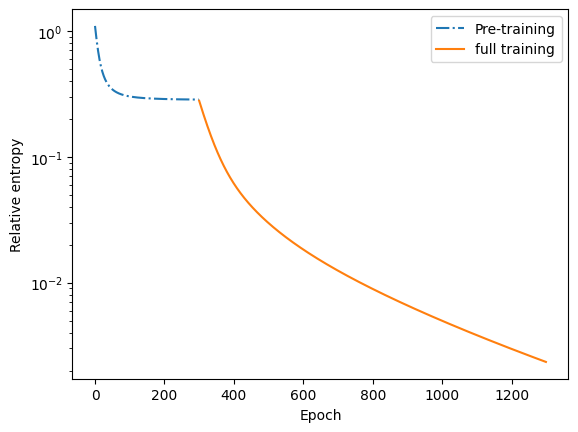

In [90]:
plt.plot(range(pre_epochs),pretraining_qre[1:], "-.", label="Pre-training")
plt.plot(range(pre_epochs,pre_epochs+epochs),qre_hist[1:], "-", label="full training")
plt.xlabel("Epoch")
plt.ylabel("Relative entropy")
plt.yscale("log")
plt.legend(loc="upper right")
plt.show()

### Compare to training the full model

If we do not have pretraining, and instead we start from all parameters equal to zero (this is the blue curve in the paper Fig.2 panel (b)), we will start from the maximally mixed state $\mathbb{I}/2^n$

In [95]:
initial_params = np.zeros(m)
qbm_state = QBM(model_ham_ops, initial_params)
print(f"Initial parameters: {qbm_state.get_coeffs()}")
print(f"Target parameters: {target_params}")
print(f"Target beta: {target_beta}")

Initial parameters: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Target parameters: [-0.5 -0.5 -0.5  0.   0.   0.   0.  -0.5 -0.5 -0.5  0.   0.   0.   0.
 -0.7 -0.7 -0.7 -0.8 -0.8 -0.8 -0.8]
Target beta: -1.0


In [96]:
# generate expectation values: quantum data
target_expects, target_state = data.generate_data(
    n_qubits,
    target_label,
    target_params,
    target_beta,
    model_ham_ops,
    depolarizing_noise,
)

In [93]:
qbm_state, max_grads_hist, qre_hist = train_qbm(
    qbm=qbm_state,
    target_expects=target_expects,
    learning_rate=full_lr,
    epochs=full_epochs,
    compute_qre=compute_qre,
    target_eta=target_eta,
    target_eta_ev=target_evals,
)

print(f"Trained parameters: {pre_qbm_state.get_coeffs()}")
print(f"Max. gradients: {max_grads_hist[-1]}")

print(f"Initial relative entropy: {qre_hist[0]}")
print(f"Trained relative entropy: {qre_hist[-1]}")

Trained parameters: [-4.24058498e-01  2.34745392e-01  2.34745392e-01 -4.24058498e-01
  1.60938668e-16  1.39476361e-16 -7.48468994e-17 -1.26739128e-17
 -4.24058498e-01  2.34745392e-01  2.34745392e-01 -4.24058498e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -5.32450176e-01  2.67920714e-01  2.67920714e-01 -5.32450176e-01
 -6.88191343e-01 -3.58101122e-01 -3.58101122e-01 -6.88191343e-01]
Max. gradients: 0.01186274307275334
Initial relative entropy: 1.166089743617617
Trained relative entropy: 0.004592889410808709


In this case the pretraining with the geometrically local model has helped to reach a smaller relative entropy.

In [94]:
print(f"With pre-training: {full_qre:.3f}")
print(f"  No pre-training: {qre_hist[-1]:.3f}")

With pre-training: 0.002
  No pre-training: 0.005
